<a href="https://colab.research.google.com/github/etha44a4n/ML-ProyectoFinal-Fertility/blob/ethan/Fertility_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Librerías y Dataset

100 voluntarios proporcionaron una muestra de semen, la cual fue analizada según los criterios de la OMS 2010. Las concentraciones de espermatozoides obtenidas fueron relacionadas con datos sociodemográficos, factores ambientales, estado de salud y hábitos de vida, con el objetivo de identificar posibles asociaciones entre estos factores y la calidad del semen.

In [1]:
#Tratamiento y visualización de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

#Modelos y entrenamiento
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import pair_confusion_matrix, contingency_matrix

#Dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# Cargar los datos
origin = pd.read_csv("/content/fertility.csv", sep=",")
df = origin.copy()

# 2. Preprocesamiento

### Atributos

**Season**: Estación del año en la que se realizó el análisis  
  - Valores posibles: `winter`, `spring`, `summer`, `fall`

**Age**: Edad al momento del análisis  
  - Rango: 18 a 36 años

**Childish diseases**: Enfermedades infantiles (por ejemplo: varicela, sarampión, paperas, polio)  
  - Valores posibles: `yes`, `no`

**Accident or serious trauma**: Accidentes o traumas graves  
  - Valores posibles: `yes`, `no`

**Surgical intervention**: Intervención quirúrgica previa  
  - Valores posibles: `yes`, `no`

**High fevers in the last year**: Fiebres altas en el último año  
  - Valores posibles: `less than three months ago`, `more than three months ago`, `no`

**Frequency of alcohol consumption**: Frecuencia de consumo de alcohol  
  - Valores posibles:  
    `several times a day`,  
    `every day`,  
    `several times a week`,  
    `once a week`,  
    `hardly ever or never`

**Smoking habit**: Hábito de fumar  
  - Valores posibles: `never`, `occasional`, `daily`

**Number of hours spent sitting per day**: Número de horas sentado por día  
  - Tipo de dato: numérico continuo

### Variable Objetivo

- **Diagnosis**: Diagnóstico de calidad seminal  
  - Valores posibles:  
    `normal (N)`,  
    `altered (O)`

In [3]:
df.head()

,Season,Age,Childish diseases,Accident or serious trauma,Surgical intervention,High fevers in the last year,Frequency of alcohol consumption,Smoking habit,Number of hours spent sitting per day,Diagnosis
0,spring,30,no,yes,yes,more than 3 months ago,once a week,occasional,16,Normal
1,spring,35,yes,no,yes,more than 3 months ago,once a week,daily,6,Altered
2,spring,27,yes,no,no,more than 3 months ago,hardly ever or never,never,9,Normal
3,spring,32,no,yes,yes,more than 3 months ago,hardly ever or never,never,7,Normal
4,spring,30,yes,yes,no,more than 3 months ago,once a week,never,9,Altered


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Season                                 100 non-null    object
 1   Age                                    100 non-null    int64 
 2   Childish diseases                      100 non-null    object
 3   Accident or serious trauma             100 non-null    object
 4   Surgical intervention                  100 non-null    object
 5   High fevers in the last year           100 non-null    object
 6   Frequency of alcohol consumption       100 non-null    object
 7   Smoking habit                          100 non-null    object
 8   Number of hours spent sitting per day  100 non-null    int64 
 9   Diagnosis                              100 non-null    object
dtypes: int64(2), object(8)
memory usage: 7.9+ KB


## Transormación de columnas Categóricas a Numéricas
Transformamos las columnas categóricas a numéricas utilizando Label Encoding para poder trabajar mejor con los modelos

In [5]:
# Identificamos columnas categóricas
categorical_cols = df.select_dtypes(include='object').columns

In [6]:
# Aplicamos Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [7]:
for col, le in label_encoders.items():
    print(f"{col}:")
    for i, class_ in enumerate(le.classes_):
        print(f"  {i} → {class_}")


Season:
  0 → fall
  1 → spring
  2 → summer
  3 → winter
Childish diseases:
  0 → no
  1 → yes
Accident or serious trauma:
  0 → no
  1 → yes
Surgical intervention:
  0 → no
  1 → yes
High fevers in the last year:
  0 → less than 3 months ago
  1 → more than 3 months ago
  2 → no
Frequency of alcohol consumption:
  0 → every day
  1 → hardly ever or never
  2 → once a week
  3 → several times a day
  4 → several times a week
Smoking habit:
  0 → daily
  1 → never
  2 → occasional
Diagnosis:
  0 → Altered
  1 → Normal


In [8]:
df.describe()

,Season,Age,Childish diseases,Accident or serious trauma,Surgical intervention,High fevers in the last year,Frequency of alcohol consumption,Smoking habit,Number of hours spent sitting per day,Diagnosis
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000
mean,1.290000,30.110000,0.870000,0.440000,0.510000,1.190000,1.97000,1.020000,10.800000,0.880000
std,1.183173,2.246861,0.337998,0.498888,0.502418,0.580752,1.10513,0.666364,33.616975,0.326599
min,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
25%,0.000000,28.000000,1.000000,0.000000,0.000000,1.000000,1.00000,1.000000,5.000000,1.000000
50%,1.000000,30.000000,1.000000,0.000000,1.000000,1.000000,2.00000,1.000000,7.000000,1.000000
75%,3.000000,32.000000,1.000000,1.000000,1.000000,2.000000,2.00000,1.000000,9.000000,1.000000
max,3.000000,36.000000,1.000000,1.000000,1.000000,2.000000,4.00000,2.000000,342.000000,1.000000


## Eliminación valores anomálos
Al observar la tabla podemos visualizar que en la columna 'Number of hours spent sitting per day' existe un máximo de 342 horas, lo cual es imposible ya que un día tiene tan solo 24 horas, por lo que, en vez de asignarle un valor ficticio, lo eliminamos.

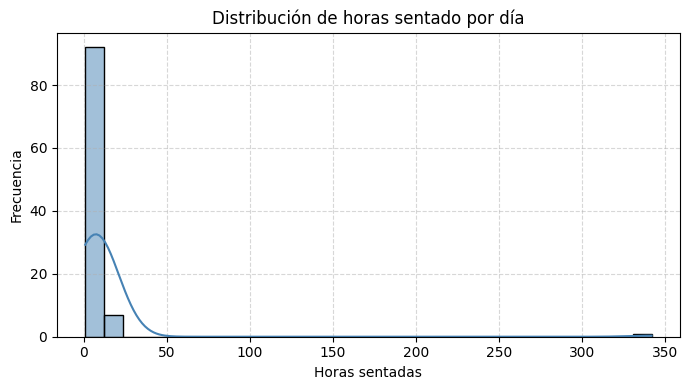

In [9]:
plt.figure(figsize=(7, 4))
sns.histplot(df['Number of hours spent sitting per day'], bins=30, kde=True, color='steelblue')
plt.title("Distribución de horas sentado por día")
plt.xlabel("Horas sentadas")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [10]:
# Filtramos todos los registros con menos de 24 horas sentadas
df = df[df['Number of hours spent sitting per day'] <= 24].copy()

In [11]:
df.describe()

,Season,Age,Childish diseases,Accident or serious trauma,Surgical intervention,High fevers in the last year,Frequency of alcohol consumption,Smoking habit,Number of hours spent sitting per day,Diagnosis
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,1.292929,30.111111,0.868687,0.444444,0.505051,1.191919,1.969697,1.020202,7.454545,0.878788
std,1.188830,2.258268,0.339461,0.499433,0.502519,0.583389,1.110750,0.669752,3.317464,0.328035
min,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,28.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,5.000000,1.000000
50%,1.000000,30.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,7.000000,1.000000
75%,3.000000,32.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,9.000000,1.000000
max,3.000000,36.000000,1.000000,1.000000,1.000000,2.000000,4.000000,2.000000,18.000000,1.000000


## Escalar datos

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('Diagnosis', axis=1))

# 3. Reducción de Dimensionalidad
## PCA
Analizamos si PCA es capaz de identificar anomalías en el conjunto de datos

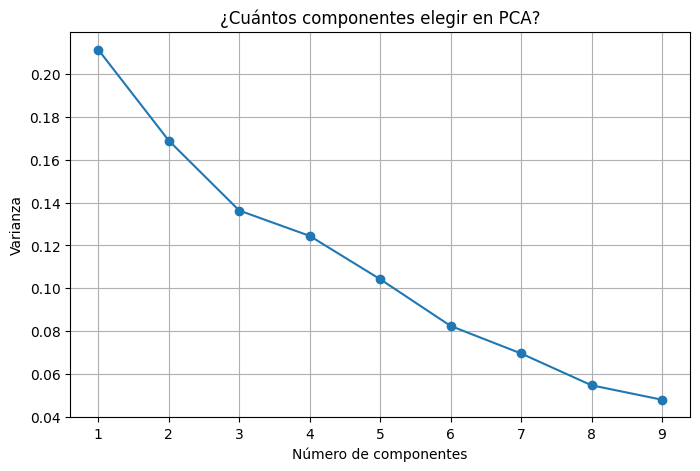

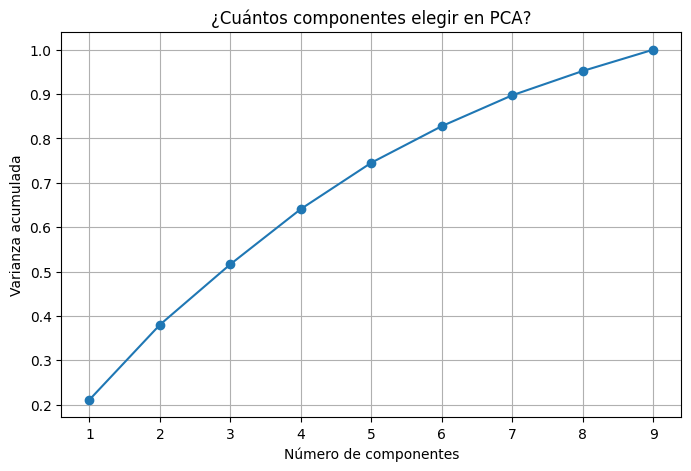

In [13]:
# Aplicamos PCA sin limitar componentes (usa todos)
pca = PCA()
pca.fit(X_scaled)

# Varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Varianza acumulada
cumulative_variance = np.cumsum(explained_variance)

# Grafico Varianza
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza')
plt.title('¿Cuántos componentes elegir en PCA?')
plt.grid(True)
plt.show()

# Gráfico Varianza Acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('¿Cuántos componentes elegir en PCA?')
plt.grid(True)
plt.show()

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

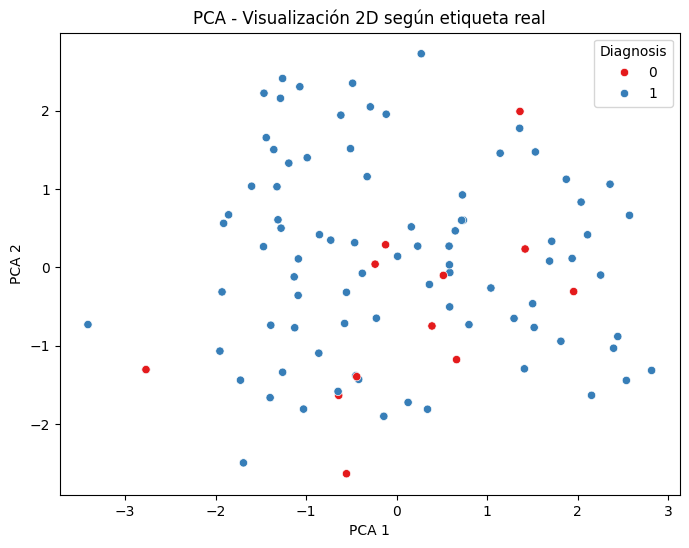

In [15]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Diagnosis'], palette='Set1')
plt.title('PCA - Visualización 2D según etiqueta real')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

# t-SNE
Dado que PCA no logra generar una representación fiel de los datos, ya que estos parecen ser no lineales, probamos con t-SNE para ver si logramos generar posibles agrupaciones

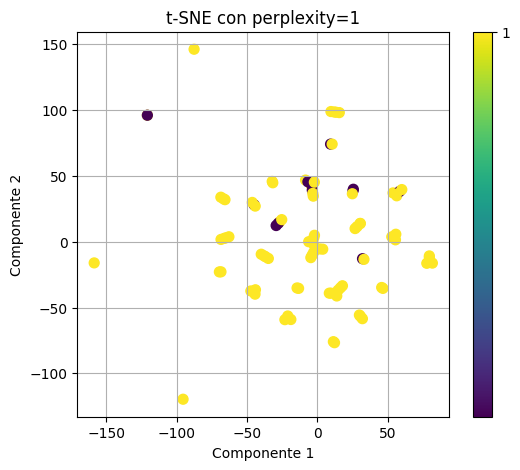

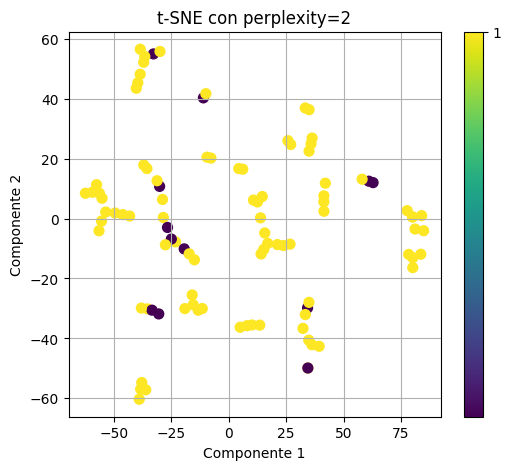

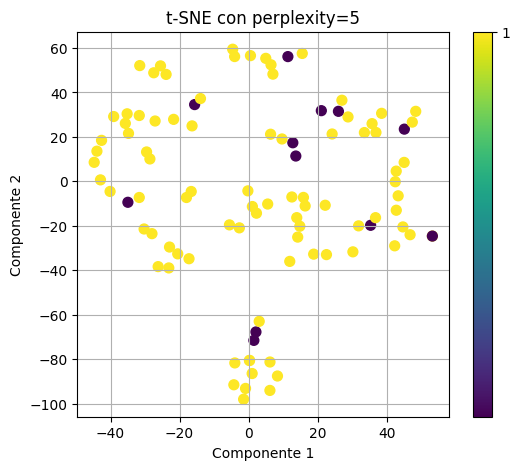

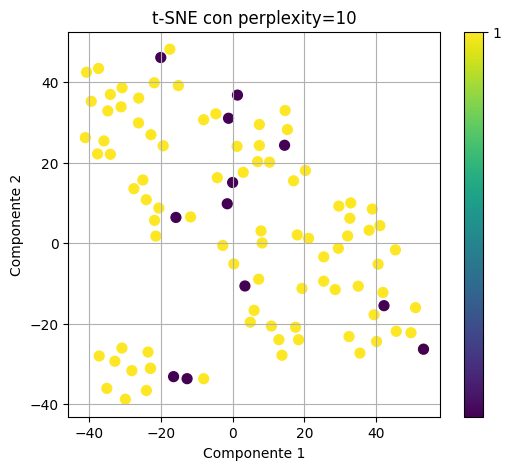

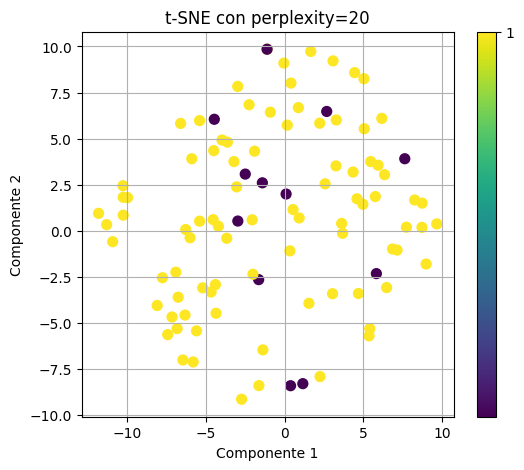

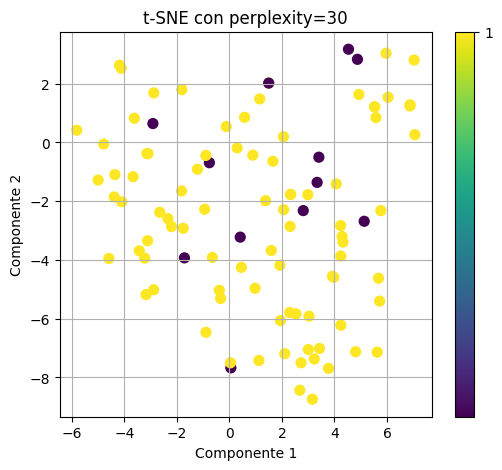

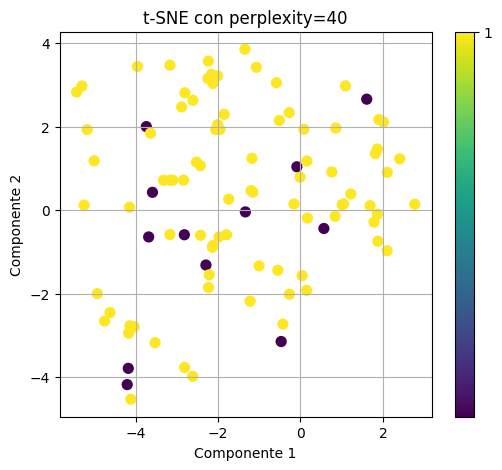

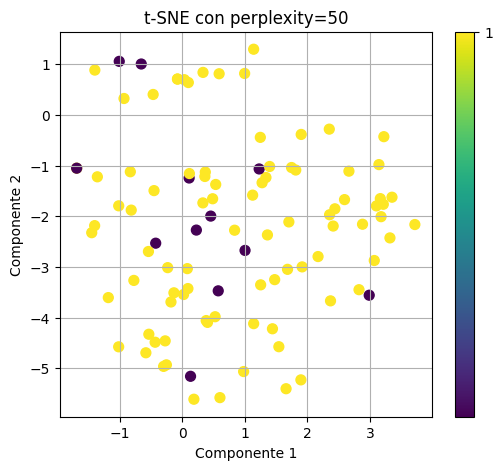

In [16]:
perplexities = [1, 2, 5, 10, 20, 30, 40, 50]

for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['Diagnosis'], cmap='viridis', s=50)
    plt.title(f't-SNE con perplexity={p}')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.colorbar(scatter, ticks=[1, 2, 3])
    plt.grid(True)
    plt.show()

Si bien t-SNE tampoco logra separar los diagnósticos, en algunos casos se logran ver pequeñas concetraciones de personas con un diagnostico alterado, particularmente con un perplexity 2

In [17]:
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

In [18]:
# Asegura que X_tsne tenga el mismo índice que df
X_tsne = pd.DataFrame(tsne.fit_transform(X_scaled), index=df.index, columns=['TSNE-1', 'TSNE-2'])

# 4. DBSCAN
Para explorar los grupos generado por t-SNE, aplicamos DBSCAN para que los agrupe y así podamos analizarlos y compararlos

In [19]:
eps_values = np.linspace(1.0, 4.5, 5)
min_samples_values = range(2, 10)

best_score = -1
best_params = None
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_tsne)
        labels = db.labels_

        # Ignorar si solo hay un clúster o todos son ruido
        if len(set(labels)) <= 1 or set(labels) == {-1}:
            continue

        try:
            score = silhouette_score(X_tsne, labels)
        except ValueError:
            continue  # Ocurre si solo hay un punto en un clúster

        results.append((eps, min_samples, score))

        if score > best_score:
            best_score = score
            best_params = (eps, min_samples)

if best_params is not None:
    print(f"Mejor Silhouette Score: {best_score:.3f}")
    print(f"Mejores parámetros: eps = {best_params[0]:.2f}, min_samples = {best_params[1]}")
else:
    print("No se encontraron parámetros válidos que generen más de un cluster.")

Mejor Silhouette Score: 0.646
Mejores parámetros: eps = 4.50, min_samples = 2


In [20]:
dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1]).fit(X_tsne)
clusters_dbscan = dbscan.fit_predict(X_tsne)

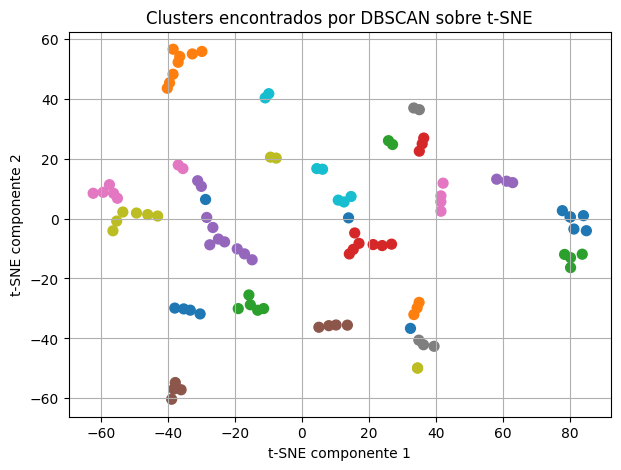

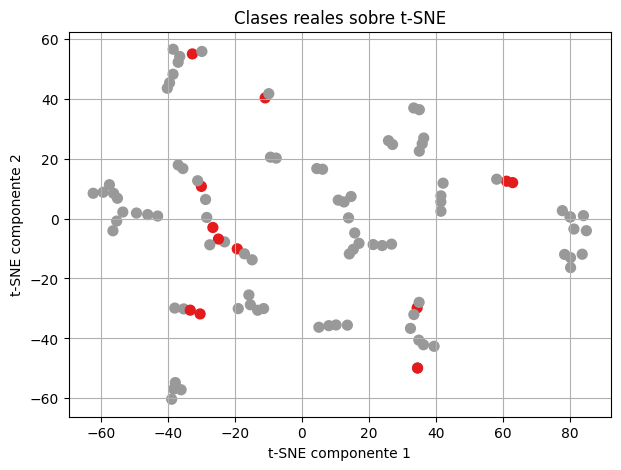

In [21]:
# Para clusters
plt.figure(figsize=(7, 5))
clusters_aligned = pd.Series(clusters_dbscan, index=X_tsne.index)
plt.scatter(X_tsne['TSNE-1'], X_tsne['TSNE-2'], c=clusters_aligned, cmap='tab10', s=50)
plt.title("Clusters encontrados por DBSCAN sobre t-SNE")
plt.xlabel("t-SNE componente 1")
plt.ylabel("t-SNE componente 2")
plt.grid(True)
plt.show()

# Para clases reales
plt.figure(figsize=(7, 5))
diagnosis_aligned = df['Diagnosis'].loc[X_tsne.index]
plt.scatter(X_tsne['TSNE-1'], X_tsne['TSNE-2'], c=diagnosis_aligned, cmap='Set1', s=50)
plt.title("Clases reales sobre t-SNE")
plt.xlabel("t-SNE componente 1")
plt.ylabel("t-SNE componente 2")
plt.grid(True)
plt.show()

# 5. Análisis de clusters
Contamos la cantidad de diagnosticos alterados dentro de cada cluster y luego comparamos grupos del mismo tamaño que tengan dichos casos vs clusters compleamente sanos

In [22]:
df['cluster'] = dbscan.labels_

In [23]:
cross = pd.crosstab(df['cluster'], df['Diagnosis'], margins=True)
print(cross)

Diagnosis   0   1  All
cluster               
-1          0   3    3
0           0   6    6
1           2   2    4
2           1   7    8
3           1   2    3
4           0   5    5
5           0   4    4
6           0   2    2
7           0   3    3
8           0   7    7
9           3   5    8
10          1   1    2
11          2   1    3
12          0   4    4
13          0   4    4
14          0   4    4
15          0   2    2
16          0   5    5
17          0   2    2
18          0   3    3
19          0   6    6
20          1   1    2
21          0   2    2
22          0   2    2
23          0   3    3
24          1   1    2
All        12  87   99


In [24]:
# Etiquetamos grupos
df['grupo'] = df['cluster'].map(lambda x: 'Sano' if x in [4, 7, 18] else ('Riesgoso' if x in [9, 11] else 'Otro'))

# Filtramos solo los clústeres de interés
df_comparacion = df[df['grupo'].isin(['Sano', 'Riesgoso'])].copy()


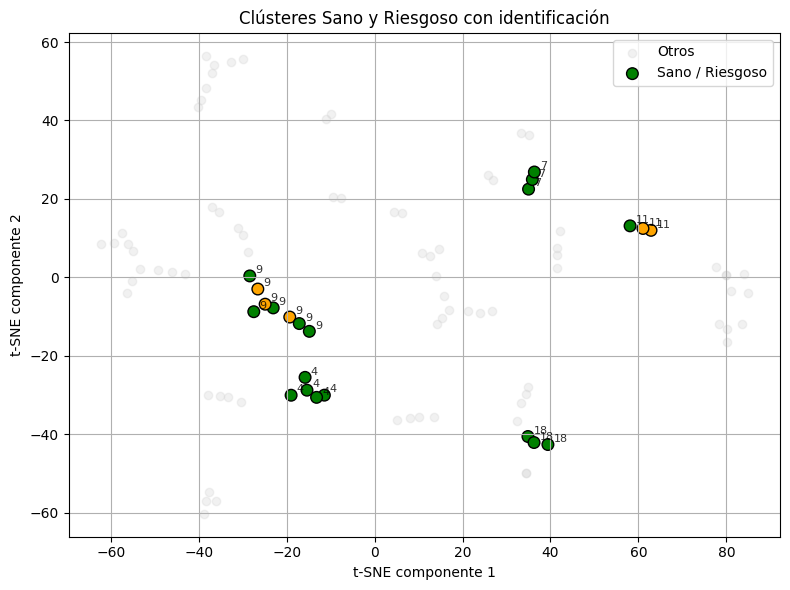

In [25]:
# Filtrar solo puntos etiquetados como 'Sano' o 'Riesgoso'
mask = df['grupo'].isin(['Sano', 'Riesgoso'])
df_focus = df.loc[mask]
tsne_focus = X_tsne.loc[mask]

# Colores por diagnóstico
colores = df_focus['Diagnosis'].map({1: 'green', 0: 'orange'})
clústeres = df_focus['cluster'].astype(str).values

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.scatter(
    X_tsne.loc[~mask, 'TSNE-1'], X_tsne.loc[~mask, 'TSNE-2'],
    c='lightgray', alpha=0.3, label='Otros'
)
sc = plt.scatter(
    tsne_focus['TSNE-1'], tsne_focus['TSNE-2'],
    c=colores, s=70, edgecolor='k', label='Sano / Riesgoso'
)

# Agregar etiquetas de número de clúster
for i, txt in enumerate(clústeres):
    plt.annotate(
        txt,
        (tsne_focus['TSNE-1'].iloc[i], tsne_focus['TSNE-2'].iloc[i]),
        fontsize=8, color='black', alpha=0.8,
        xytext=(4, 2), textcoords='offset points'
    )

plt.title("Clústeres Sano y Riesgoso con identificación")
plt.xlabel("t-SNE componente 1")
plt.ylabel("t-SNE componente 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
print("Distribución del diagnóstico en cada grupo:")
print(pd.crosstab(df_comparacion['grupo'], df_comparacion['Diagnosis'], normalize='index'))


Distribución del diagnóstico en cada grupo:
Diagnosis         0         1
grupo                        
Riesgoso   0.454545  0.545455
Sano       0.000000  1.000000


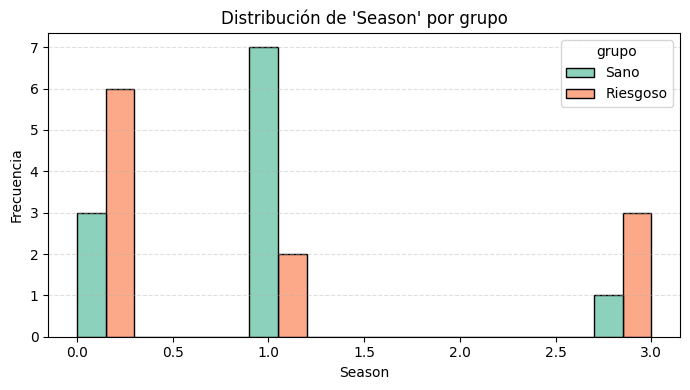

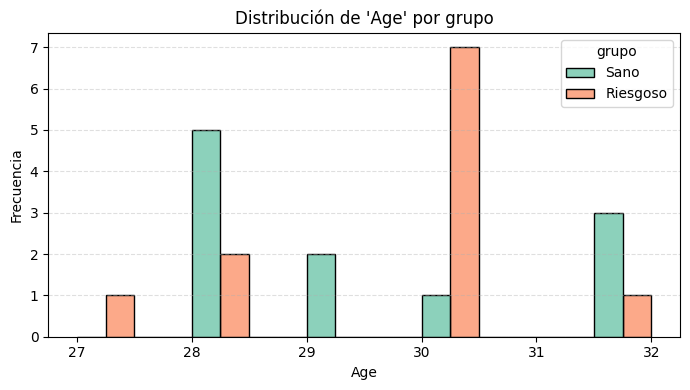

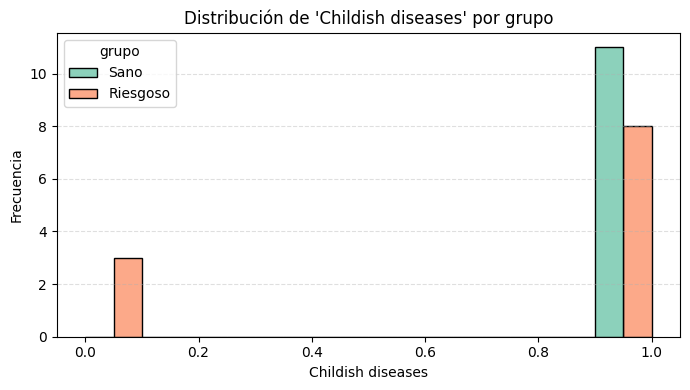

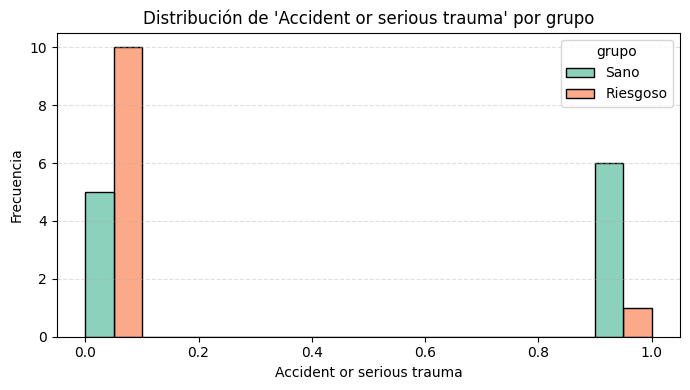

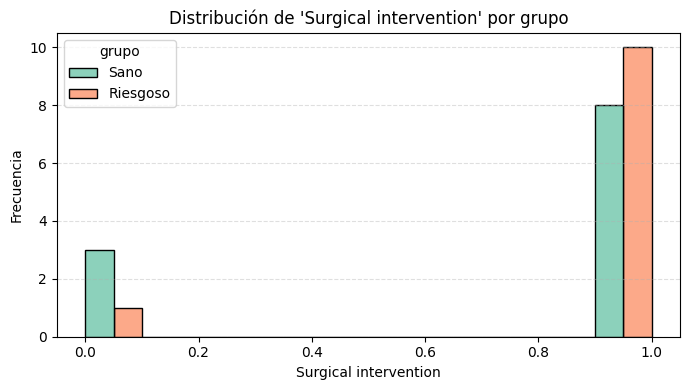

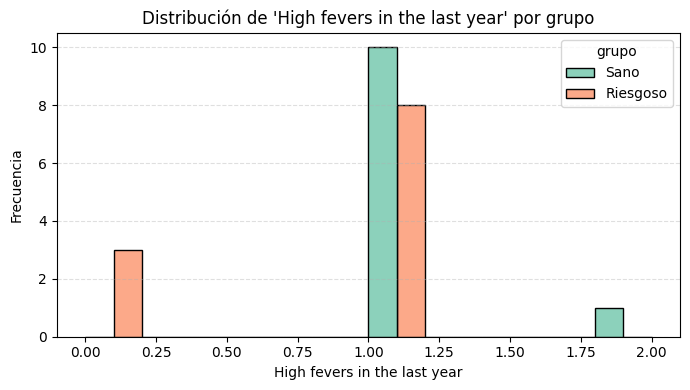

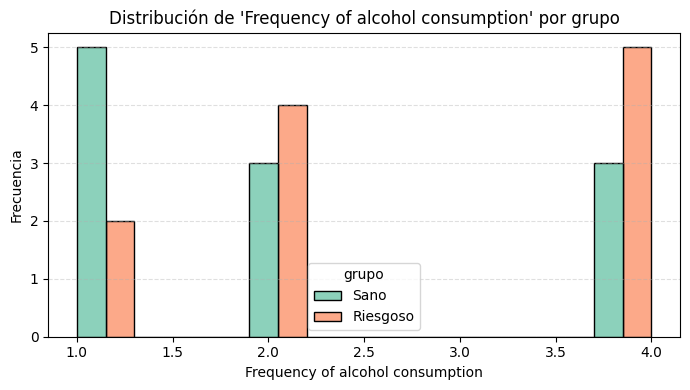

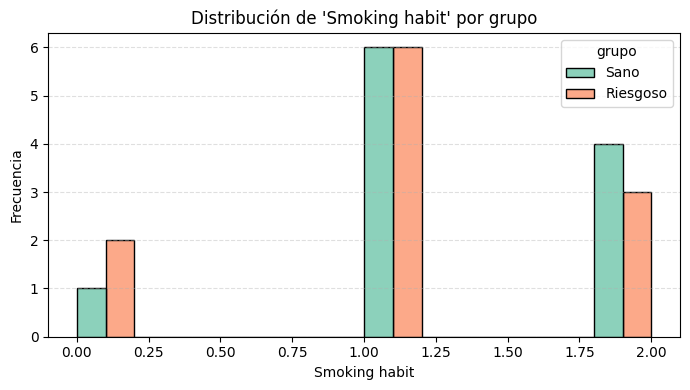

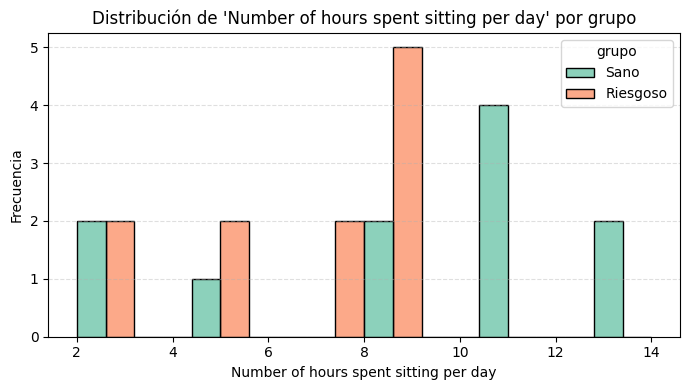

In [28]:
# Seleccionamos solo los datos de los grupos "Sano" y "Riesgoso"
df_comparacion = df[df['grupo'].isin(['Sano', 'Riesgoso'])].copy()

# Columnas numéricas para graficar
vars_numericas = [
    'Season', 'Age', 'Childish diseases', 'Accident or serious trauma',
    'Surgical intervention', 'High fevers in the last year',
    'Frequency of alcohol consumption', 'Smoking habit',
    'Number of hours spent sitting per day'
]

# Graficar histogramas por variable
for col in vars_numericas:
    plt.figure(figsize=(7, 4))
    sns.histplot(data=df_comparacion, x=col, hue='grupo', bins=10, kde=False, palette='Set2', multiple='dodge')
    plt.title(f"Distribución de '{col}' por grupo")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [29]:
# Selecciona columnas numéricas, excluyendo columnas auxiliares
encoded_features = df_comparacion.select_dtypes(include='number').drop(columns=['cluster', 'Diagnosis'], errors='ignore')

In [30]:
df_comparacion.groupby('grupo')[encoded_features.columns].mean().round(2)

,Season,Age,Childish diseases,Accident or serious trauma,Surgical intervention,High fevers in the last year,Frequency of alcohol consumption,Smoking habit,Number of hours spent sitting per day
grupo,,,,,,,,,
Riesgoso,1.00,29.55,0.73,0.09,0.91,0.73,2.73,1.09,6.73
Sano,0.91,29.45,1.00,0.55,0.73,1.09,2.09,1.27,9.09


In [31]:
group_means = df_comparacion.groupby('grupo')[encoded_features.columns].mean()
diferencias = (group_means.loc['Riesgoso'] - group_means.loc['Sano']).abs().sort_values(ascending=False)
print("Variables más distintas entre grupos:\n")
print(diferencias)

Variables más distintas entre grupos:

Number of hours spent sitting per day    2.363636
Frequency of alcohol consumption         0.636364
Accident or serious trauma               0.454545
High fevers in the last year             0.363636
Childish diseases                        0.272727
Smoking habit                            0.181818
Surgical intervention                    0.181818
Age                                      0.090909
Season                                   0.090909
dtype: float64


In [32]:
# Agrupamos y contamos valores específicos
conteo_alcohol = df[df['grupo'].isin(['Sano', 'Riesgoso'])] \
    .groupby(['grupo', 'Frequency of alcohol consumption']) \
    .size().unstack().fillna(0).astype(int)

# Renombramos columnas con etiquetas interpretables
conteo_alcohol.columns = [
    #'0 → every day',
    '1 → hardly ever or never',
    '2 → once a week',
    #'3 → several times a day',
    '4 → several times a week'
]

print("Cantidad de individuos por grupo y nivel de consumo de alcohol:\n")
print(conteo_alcohol)

Cantidad de individuos por grupo y nivel de consumo de alcohol:

          1 → hardly ever or never  2 → once a week  4 → several times a week
grupo                                                                        
Riesgoso                         2                4                         5
Sano                             5                3                         3


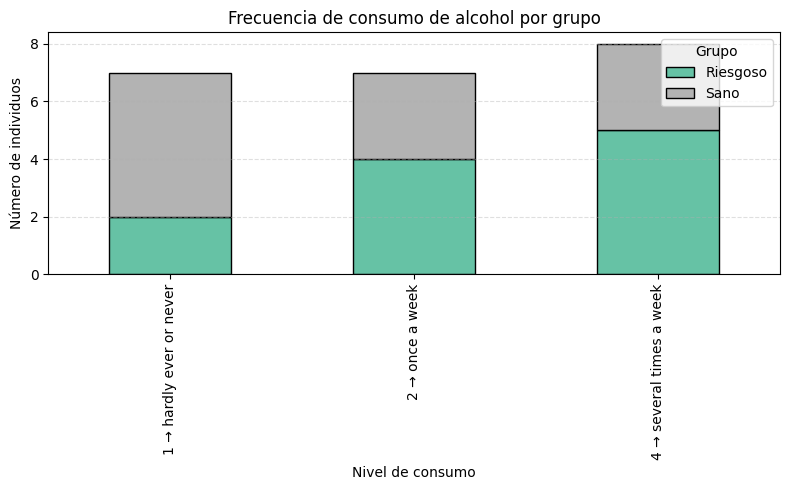

In [33]:
conteo_alcohol.T.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 5),
    colormap='Set2',
    edgecolor='black'
)
plt.title("Frecuencia de consumo de alcohol por grupo")
plt.ylabel("Número de individuos")
plt.xlabel("Nivel de consumo")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title='Grupo')
plt.tight_layout()
plt.show()

Al comparar clústeres, se observan diferencias clave que podrían estar asociadas al riesgo de diagnóstico alterado. El grupo Riesgoso muestra mayor presencia de antecedentes traumáticos, intervenciones quirúrgicas y fiebre reciente, además de un consumo de alcohol más frecuente. En cambio, el grupo Sano tiende a haber tenido más enfermedades infantiles en su historial, lo que sorprendentemente podría tener un efecto protector. Aunque ambos grupos tienen edad y hábitos de tabaquismo similares, el grupo Sano reporta más horas sentado, lo cual parece contradictorio pero también puede reflejar sesgos en la percepción o medición


